In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle

import numpy as np
import pandas as pd

import settings as conf

In [3]:
output_dir = os.path.join(conf.DELIVERABLES_DIR, 'roc_validation', 'classifier_tables')
os.makedirs(output_dir, exist_ok=True)

# Load ROC data

In [4]:
roc_data = {}
roc_labels = {}

## MultiXcan - mashr

In [5]:
roc_data['multixcan_mashr'] = pd.read_csv(
    os.path.join(output_dir, 'smultixcan-mashr-classifier_data.tsv.gz'),
    sep='\t',
)

In [6]:
roc_data['multixcan_mashr'].shape

(19119, 3)

In [7]:
roc_data['multixcan_mashr'].head(2)

,score,predicted_class,true_class
0,5.986574,1,0
1,5.540858,1,0


In [8]:
roc_labels['multixcan_mashr'] = 'MultiXcan'

## fastENLOC with torus

In [9]:
roc_data['fastenloc_torus'] = pd.read_csv(
    os.path.join(output_dir, 'fastenloc-torus-classifier_data.tsv.gz'),
    sep='\t',
)

In [10]:
roc_data['fastenloc_torus'].shape

(19709, 3)

In [11]:
roc_data['fastenloc_torus'].head(2)

,score,predicted_class,true_class
0,0.02179,0,0
1,0.06083,0,0


In [12]:
roc_labels['fastenloc_torus'] = 'fastENLOC'

## Combined

In [13]:
roc_data['combined'] = pd.read_csv(
#     os.path.join(output_dir, 'combined-classifier_data.tsv.gz'),
    os.path.join(output_dir, 'combined-cutoff-classifier_data.tsv.gz'),
    sep='\t',
)

In [14]:
roc_data['combined'].shape

(19119, 3)

In [15]:
roc_data['combined'].head(2)

,score,predicted_class,true_class
0,5.986574,1,0
1,5.540858,1,0


In [16]:
roc_labels['combined'] = 'Combined'

# ROC/PR plot functions

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def plot_roc(data, method_key, fig, ax):
    print(f'{method_key}:')
    
    acc = accuracy_score(data['true_class'], data['predicted_class'])
    print(f'  Accuracy: {acc:.3f}')
    
    bacc = balanced_accuracy_score(data['true_class'], data['predicted_class'])
    print(f'  Balanced Accuracy: {bacc:.3f}')
    
    roc_auc = roc_auc_score(data['true_class'], data['score'])
    print(f'  ROC area: {roc_auc:.3f}')
    
    fpr, tpr, thresholds = roc_curve(data['true_class'], data['score'])
    print(f'  Points for ROC curve: {len(fpr)}')
    
    label = f'{roc_labels[method_key]} - AUC: {roc_auc:.3f}'
    sns.lineplot(x=fpr, y=tpr, estimator=None, label=label, ax=ax)

In [19]:
# methods selected to show
#selected_methods = ('multixcan_mashr', 'fastenloc_torus', 'multixcan_en')
selected_methods = ('multixcan_mashr', 'fastenloc_torus', 'combined')

# ROC curve

multixcan_mashr:
  Accuracy: 0.907
  Balanced Accuracy: 0.571
  ROC area: 0.640
  Points for ROC curve: 247
fastenloc_torus:
  Accuracy: 0.946
  Balanced Accuracy: 0.555
  ROC area: 0.613
  Points for ROC curve: 1039
combined:
  Accuracy: 0.964
  Balanced Accuracy: 0.569
  ROC area: 0.598
  Points for ROC curve: 72


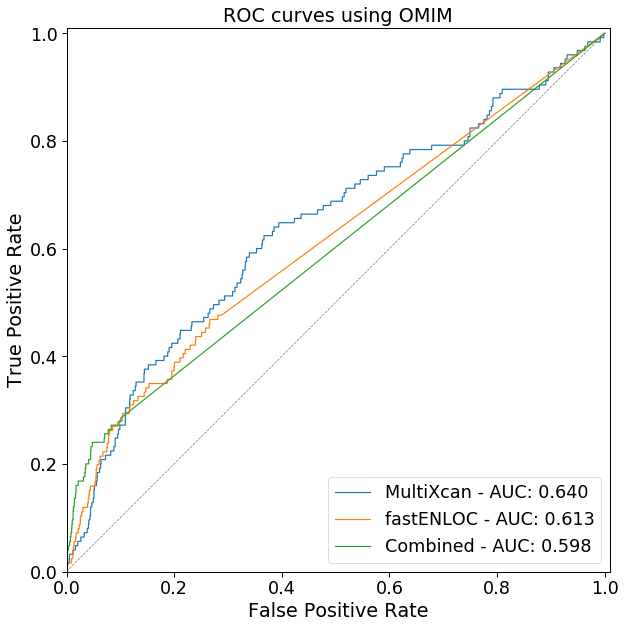

In [20]:
with sns.plotting_context('paper', font_scale=2.00):
    fig, ax = plt.subplots(figsize=(10, 10))

    for k in selected_methods:
        plot_roc(roc_data[k], k, fig, ax)
    
    ax.set_title('ROC curves using OMIM')
    ax.plot([0.0, 1.00], [0.0, 1.00], color='gray', linewidth=0.75, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlim([0.0, 1.01])
    ax.set_ylim([0.0, 1.01])
    ax.legend(loc="lower right")
    ax.set_aspect('equal')

# PR curve

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import minmax_scale

In [22]:
def plot_pr_raw_data(recall, precision, label, **kwargs):
    sns.lineplot(x=recall, y=precision, label=label, **kwargs)

    
def plot_pr(data, method_key, fig, ax, estimator=None):
    precision, recall, thresholds = precision_recall_curve(data['true_class'], data['score'])
    
    ap = average_precision_score(data['true_class'], data['score'])
    
    label = f'{roc_labels[method_key]} - AP: {ap:.3f}'
    plot_pr_raw_data(recall, precision, label, estimator=estimator, ax=ax)

In [23]:
def get_random_classifier_pr(data, reps=10, min_val=0, max_val=1):
    random_precision = []
    random_recall = []

    for i in range(reps):
        random_score = minmax_scale(np.random.rand(data['true_class'].shape[0]), feature_range=(min_val, max_val))
        rp, rr, _ = precision_recall_curve(data['true_class'], random_score)
        random_precision.extend(rp)
        random_recall.extend(rr)
    
    return np.array(random_recall), np.array(random_precision)

In [24]:
random_recall, random_precision = get_random_classifier_pr(roc_data['multixcan_mashr'], reps=100)

In [25]:
len(random_recall)

1895038

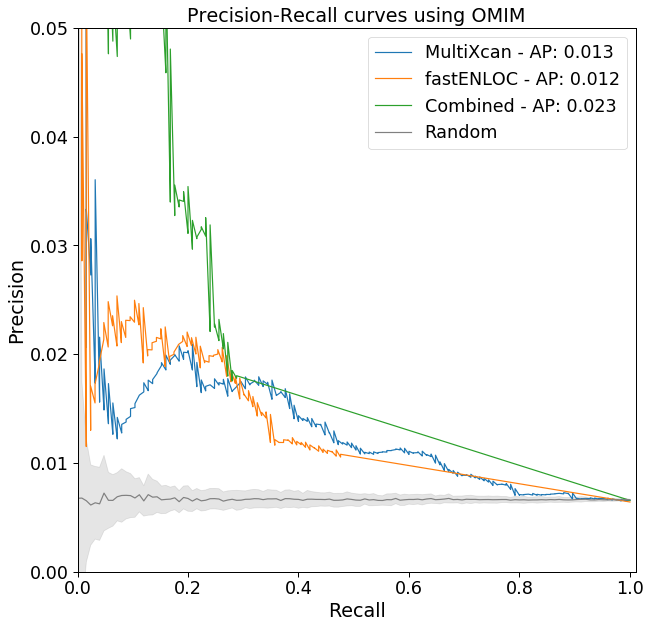

In [26]:
with sns.plotting_context('paper', font_scale=2.00):
    fig, ax = plt.subplots(figsize=(10, 10))

    for k in selected_methods:
        plot_pr(roc_data[k], k, fig, ax)
    
    # add random classifier
#     random_recall, random_precision = get_random_classifier_pr(roc_data['multixcan_mashr'].shape[0], roc_data['multixcan_mashr'])
    plot_pr_raw_data(random_recall, random_precision, 'Random', estimator='mean', ax=ax, ci='sd', color='gray')
    
    ax.set_title('Precision-Recall curves using OMIM')
    #ax.plot([0.00, 1.00], [1.00, 0.00], color='gray', linewidth=0.50)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim([0.0, 1.01])
    ax.set_ylim([0.0, 0.05])
    ax.legend(loc="upper right")
#     ax.set_aspect('equal')